# Pima Indians Diabetes - Analysis & Predictions


---

# Problem statement

__Dataset__:   

- Originally from the National Institute of Diabetes and Digestive and Kidney Diseases.
- It is an extract from a larger database: all the observations / patients here are females at least 21 years old of Pima Indian heritage.

__Who are Pima Indians ?__

_"The Pima [... ]are a group of Native Americans living in an area consisting of what is now central and southern Arizona. The majority population of the surviving two bands [...] are based in two reservations"_   
Source: Wikipedia

__What is diabete?__  
_"It is a group of metabolic disorders characterized by a high blood sugar level (hyperglycemia) over a prolonged period of time. Symptoms often include frequent urination, increased thirst and increased appetite. If left untreated, diabetes can cause many health complications._  
Source: [Wikipedia](https://en.wikipedia.org/wiki/Diabetes)

__Goal:__

diagnostically predict whether or not a patient has diabetes, based on certain measurements. The target is "Outcome", all the other columns are predictor variables (or features)

---

# First Insight

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
#sns.set()

import warnings
warnings.filterwarnings('ignore')
#%matplotlib 


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Stats
import scipy.stats as ss
from scipy import interp
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

Attribute Informations:  


- Number of times pregnant
- Plasma glucose concentration a 2 hours in an oral glucose tolerance test
- Diastolic blood pressure (mm Hg)
- Triceps skin fold thickness (mm)
- 2-Hour serum insulin (mu U/ml)
- Body mass index (weight in kg/(height in m)^2)
- Diabetes pedigree function
- Nb of years
- Class variable (0 or 1) 268 of 768 are 1, the others are 0

In [2]:
df = pd.read_csv('diabetes.csv')
# ('../input/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Surprisingly there isn't any missing value among the 768 observations :

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


---

# Exploratory Data Analysis

### The target

Our dataset is lightly imbalaced (not too much such as in anomaly detection)

<AxesSubplot:>

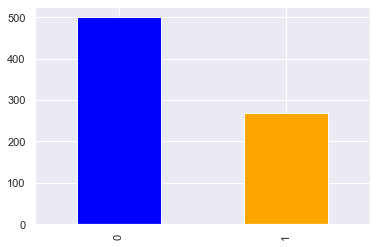

In [4]:
df.Outcome.value_counts().plot.bar(color=['blue', 'orange'])

### Predicators variables

In order to have a big picture we draw the scatter matrix :

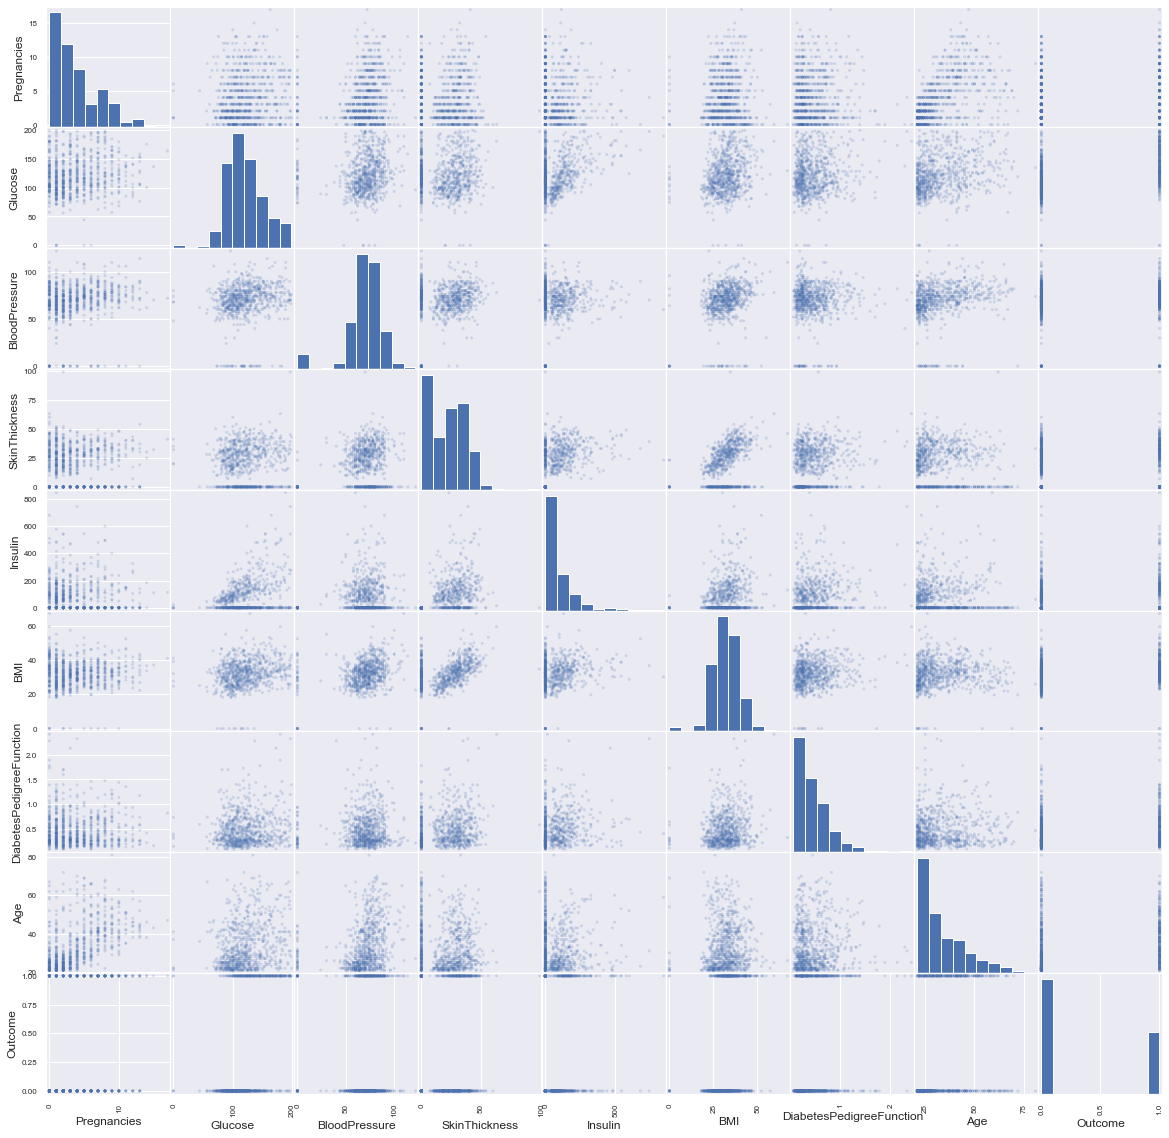

In [5]:
pd.plotting.scatter_matrix(df, alpha=0.2, figsize=(20, 20));

Let's see the number of zeros if we replace them with NaNs:

In [6]:
df.replace(0, np.NaN).isnull().sum().sort_values()

DiabetesPedigreeFunction      0
Age                           0
Glucose                       5
BMI                          11
BloodPressure                35
Pregnancies                 111
SkinThickness               227
Insulin                     374
Outcome                     500
dtype: int64

- "Pregnancies", "Outcome" can contain zeros.
- The skin thickness can not be equal to zero:

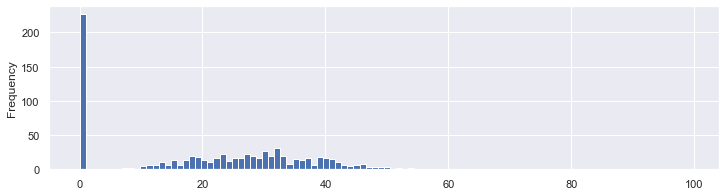

In [7]:
df.SkinThickness.plot.hist(bins=100,figsize=(12, 3));

For the insulin, it's not clear / sure...

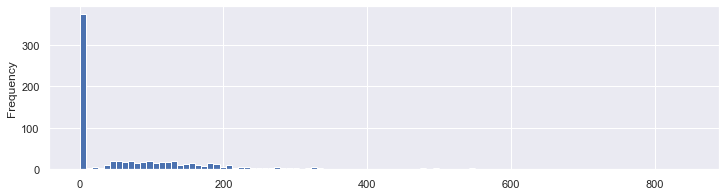

In [8]:
df.Insulin.plot.hist(bins=100,figsize=(12, 3));

We can see roughly the same proportion of zero values and non zero values of insulin depending on the outcome. So this might not have an influence on our prediction

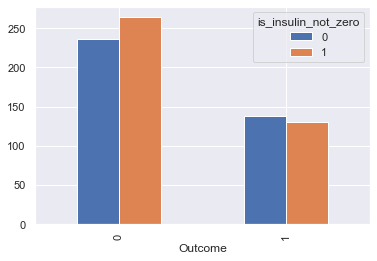

In [9]:
df_temp = df.copy()
df_temp['is_insulin_not_zero'] = (df_temp.Insulin != 0).astype(int)
df_temp.groupby(['Outcome', 'is_insulin_not_zero'])\
    .count()[['Insulin']]\
    .reset_index()\
    .pivot(index='Outcome', columns='is_insulin_not_zero', values='Insulin')\
    .plot.bar();

we'll try with & without replacing zero values

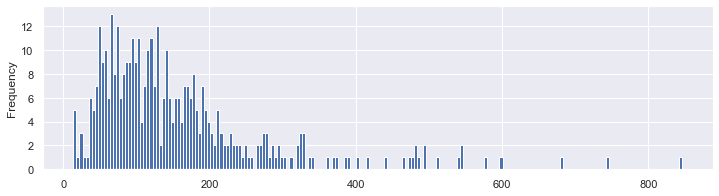

In [10]:
df.Insulin.replace(0, np.NaN).plot.hist(bins=200,figsize=(12, 3));

In reality, all the other columns are measures that can't be equal to zero, such as the BMI. So it's safe to count them as NaNs. In order to replace those eroneous values, we need to understand their distributions a little bit better.

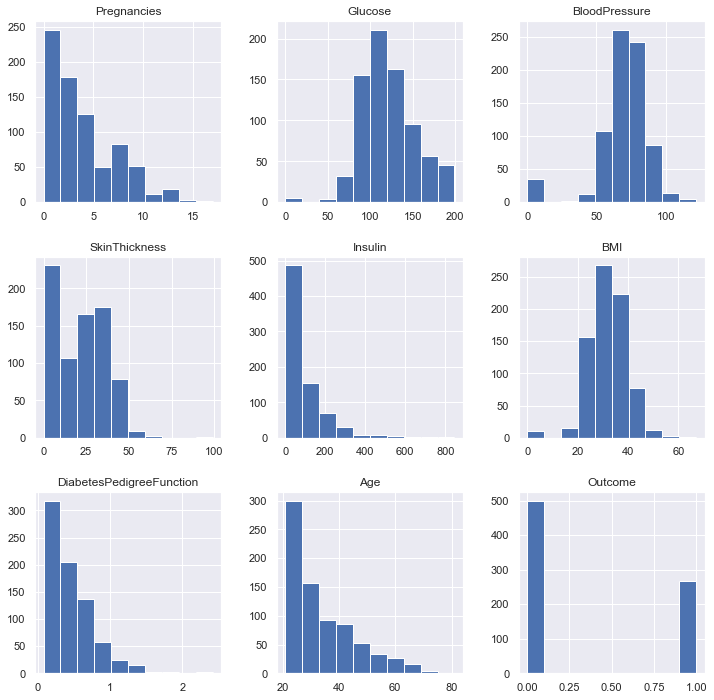

In [11]:
df.hist(figsize = (12, 12));

there is no patient with an age strictly positive and under 21 as specified in the context:

In [12]:
df[(df.Age > 0) & (df.Age < 21)].shape[0]

0

Finally, here are the variables where we need to replace zeros: Glucose, BloodPressure, SkinThickness, BMI, Age. And we are not sure for the insulin predicator. What are the basic statistics ?

In [13]:
df.replace(0, np.NaN).describe().T.round(1)

,count,mean,std,min,25%,50%,75%,max
Pregnancies,657.0,4.5,3.2,1.0,2.0,4.0,7.0,17.0
Glucose,763.0,121.7,30.5,44.0,99.0,117.0,141.0,199.0
BloodPressure,733.0,72.4,12.4,24.0,64.0,72.0,80.0,122.0
SkinThickness,541.0,29.2,10.5,7.0,22.0,29.0,36.0,99.0
Insulin,394.0,155.5,118.8,14.0,76.2,125.0,190.0,846.0
BMI,757.0,32.5,6.9,18.2,27.5,32.3,36.6,67.1
DiabetesPedigreeFunction,768.0,0.5,0.3,0.1,0.2,0.4,0.6,2.4
Age,768.0,33.2,11.8,21.0,24.0,29.0,41.0,81.0
Outcome,268.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0


Now, the pairs plot allows us to see the distribution of a single variable while the scatter plots on the upper and lower triangles show the relationship (or lack thereof) between two variables.

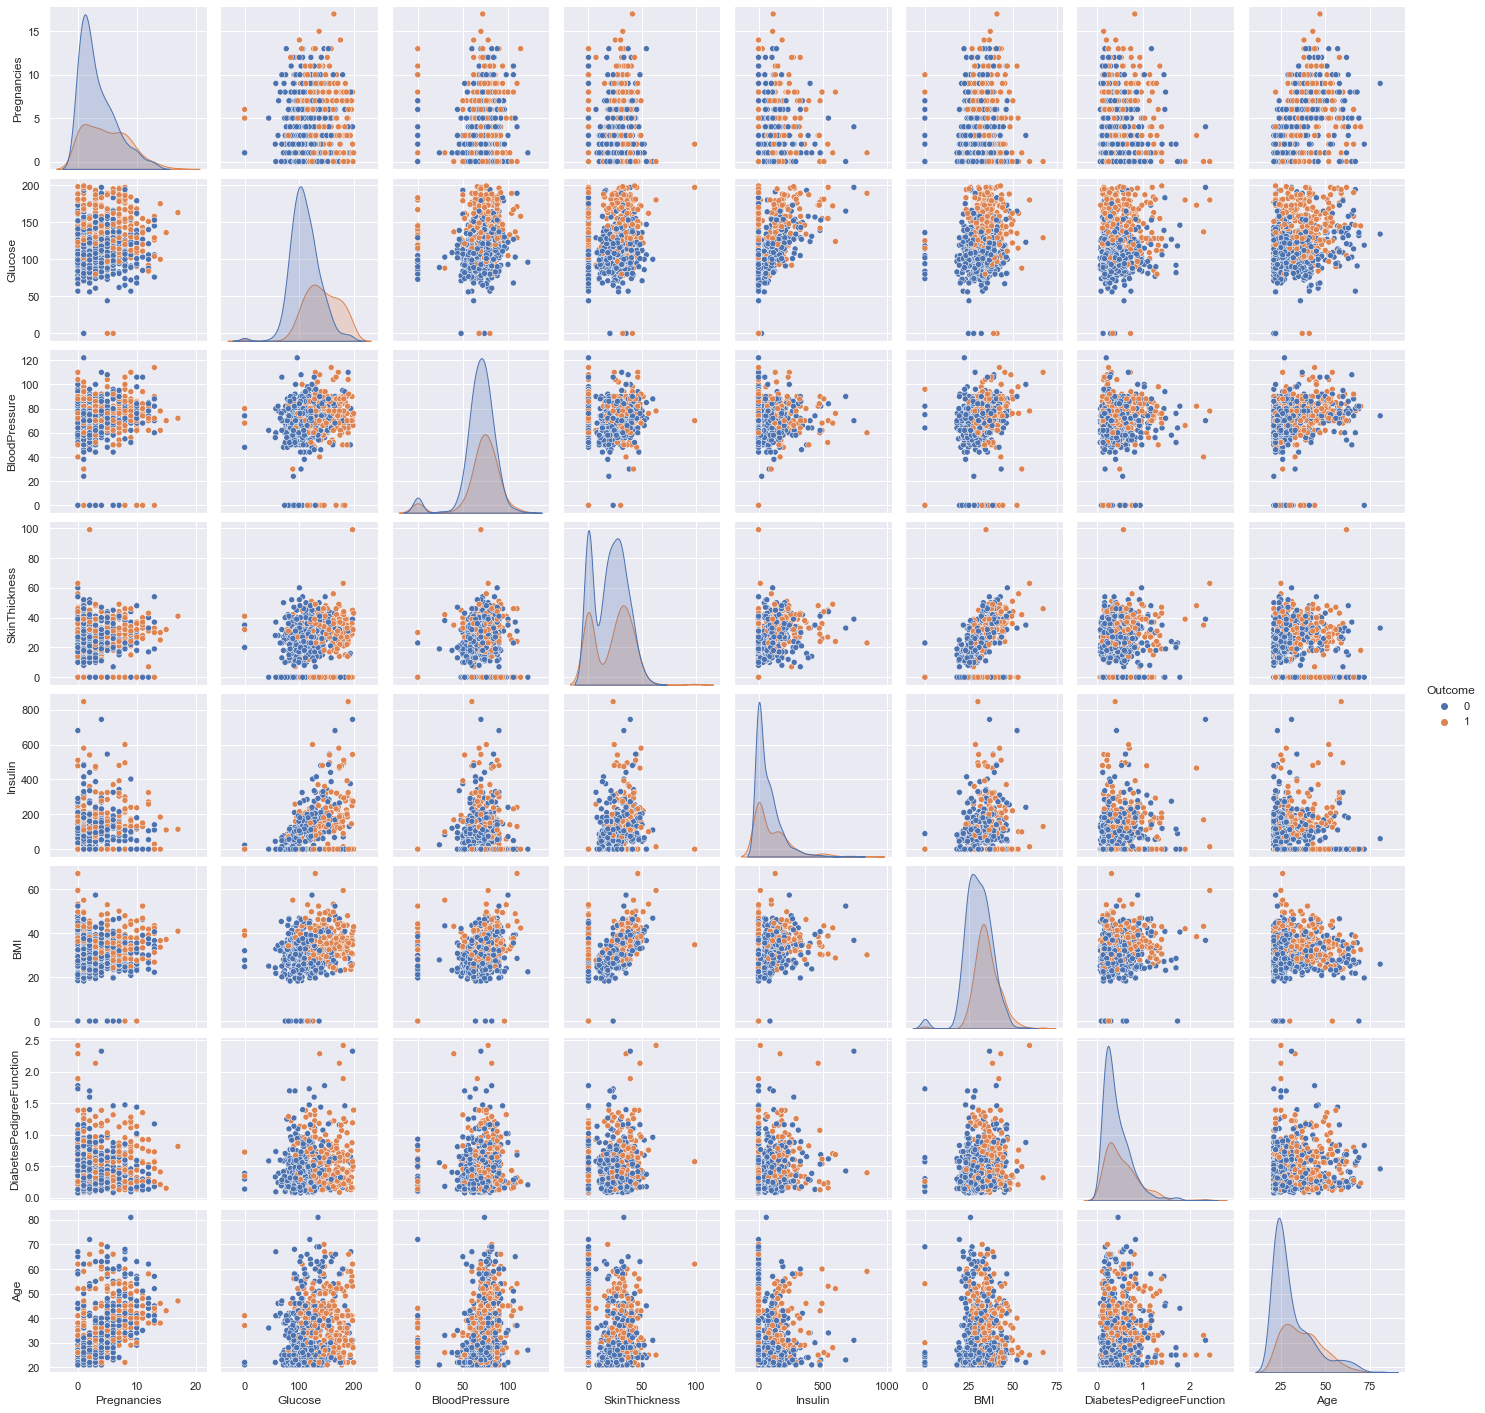

In [14]:
sns.pairplot(df, hue='Outcome');

### Correlations

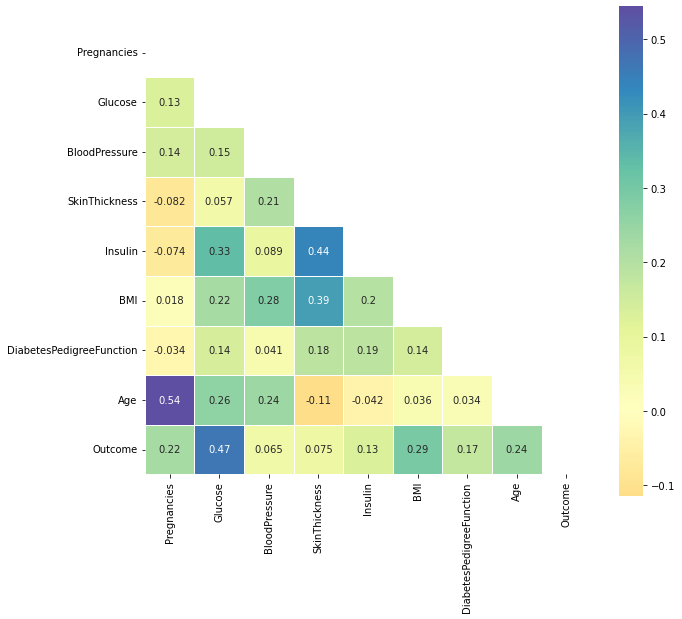

In [3]:
def plot_corr(df_):
    corr = df_.corr()
    #print(corr)

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(10, 18))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, center=0, square=True, cmap='Spectral', linewidths=.5, cbar_kws={"shrink": .5}, annot=True);

plot_corr(df)

### Outliers

it's not always a good idea to compare the boxplots of each predicator on the same graph because they have various scales. But here it allows us to compare them:

![title](outliers.png)

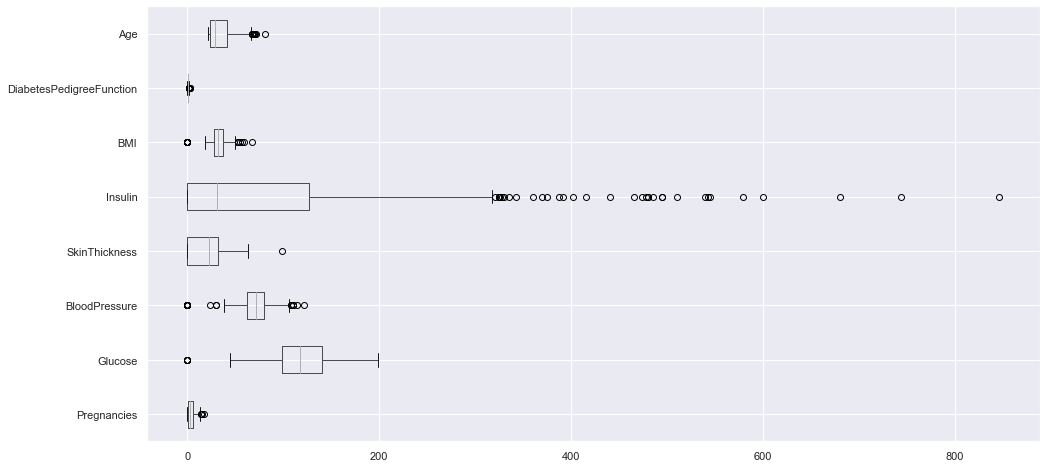

In [16]:
df.loc[:, df.columns != "Outcome"].boxplot(vert=False, figsize=(16, 8));

### The body mass index

According to Wikipedia _"The BMI is a value derived from the mass (weight) and height of an individual. It is defined as the body mass divided by the square of the body height, and is universally expressed in units of kg/m2, resulting from mass in kilograms and height in metres."_

30 kg/m² is the limit to obesity

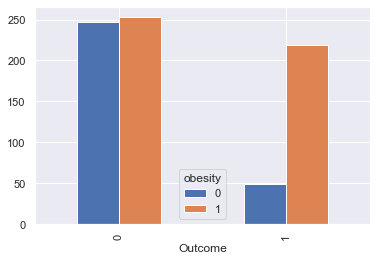

In [17]:
df_temp = df[['BMI', 'Outcome']].copy()
df_temp['obesity'] = (df_temp['BMI'] >= 30).astype(int)

df_temp_gpd = df_temp.groupby(['Outcome', 'obesity']).count()\
    .reset_index()\
    .pivot(index='Outcome', columns='obesity', values='BMI')
    
df_temp_gpd.plot.bar();

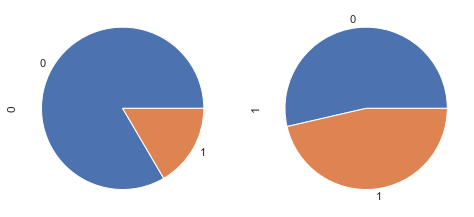

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
df_temp_gpd.T.loc[0].plot.pie(ax = axes[0],subplots=True);
df_temp_gpd.T.loc[1].plot.pie(ax = axes[1],subplots=True);

---

# Feature Engineering

In [19]:
def display_scatter(df, feat_x, feat_y):
    df.plot.scatter(title=f"{feat_y} vs {feat_x}", x=feat_x, y=feat_y, c='Outcome', 
                    colormap='viridis', figsize=(10, 5), alpha=0.3)
    

def display_bars(df, feat_x, feat_y, new_feat, threshold_x, threshold_y):
    _df = df[[feat_x, feat_y, 'Outcome']]
    _df[new_feat] = (_df[feat_x] <= threshold_x) & (_df[feat_y] <= threshold_y).astype(int)
    _df = _df.groupby(['Outcome', new_feat])\
        .count()[[feat_x]]\
        .reset_index()\
        .pivot(index='Outcome', columns=new_feat, values=feat_x)\
        .plot.bar();


def display_pie(df, feat_x, feat_y, new_feat, threshold_x, threshold_y):
    _df = df[[feat_x, feat_y, 'Outcome']]
    _df[new_feat] = (_df[feat_x] <= threshold_x) & (_df[feat_y] <= threshold_y).astype(int)
    _df = _df.groupby(['Outcome', new_feat])\
        .count()[[feat_x]]\
        .reset_index()\
        .pivot(index='Outcome', columns=new_feat, values=feat_x)\
    
    fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(8, 4))
    _df.T.loc[True].plot.pie(ax=axes[0], subplots=True) 
    _df.T.loc[False].plot.pie(ax=axes[1], subplots=True)

### Age vs. Glucose

By drawing the ...

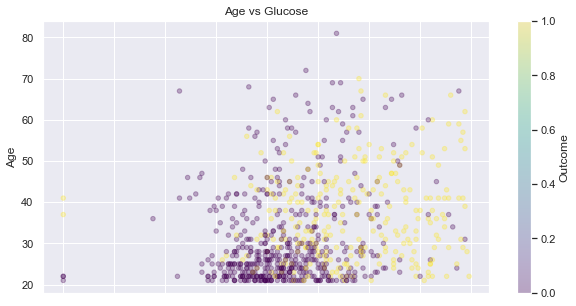

In [20]:
feat_1, feat_2 = 'Age', 'Glucose', 
display_scatter(df, feat_2, feat_1)

Let's compare the population on the down-left corner of the picture above versus the rest:

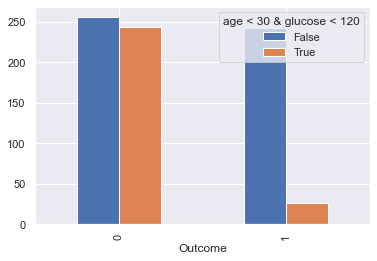

In [21]:
display_bars(df, feat_1, feat_2, 'age < 30 & glucose < 120', 30, 120 )

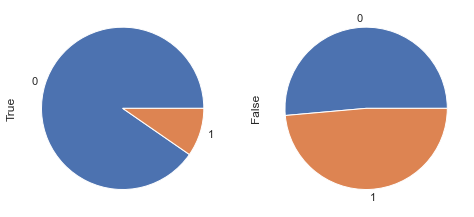

In [22]:
display_pie(df, feat_1, feat_2, 'age < 30 & glucose < 120', 30, 120 )

### Pregnancies and Age

It seems that there are more non diabetic young persons with a low number of pregnancy - see the down-left corner of the following scatter plot:

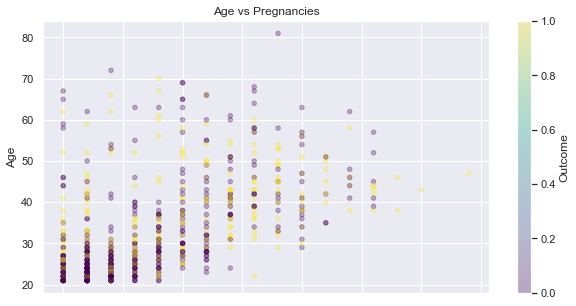

In [23]:
feat_1, feat_2 = 'Age', 'Pregnancies', 
display_scatter(df, feat_2, feat_1)

Let's compare the population on the down-left corner of the picture above versus the rest:

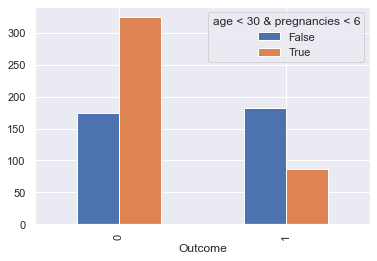

In [24]:
display_bars(df, feat_1, feat_2, 'age < 30 & pregnancies < 6', 30, 6)

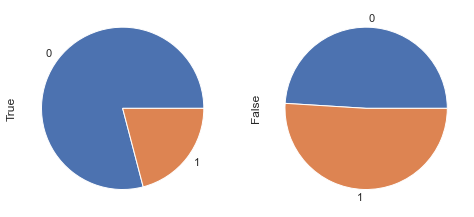

In [25]:
display_pie(df, feat_1, feat_2, 'age < 30 & pregnancies < 6', 30, 6)

### Glucose and BloodPressure

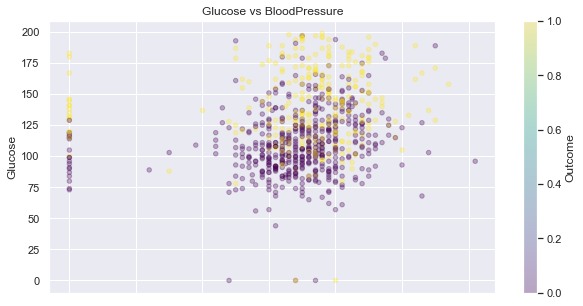

In [26]:
feat_1, feat_2 = 'Glucose', 'BloodPressure', 
display_scatter(df, feat_2, feat_1)

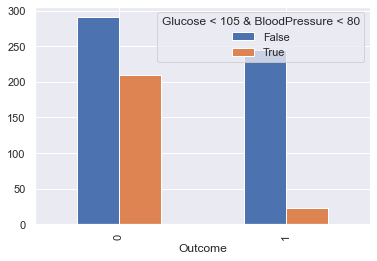

In [27]:
display_bars(df, feat_1, feat_2, 'Glucose < 105 & BloodPressure < 80', 105, 80)

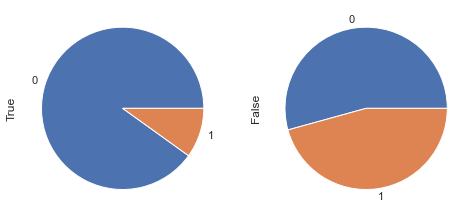

In [28]:
display_pie(df, feat_1, feat_2, 'Glucose < 105 & BloodPressure < 80', 105, 80)

### SkinThickness and BMI

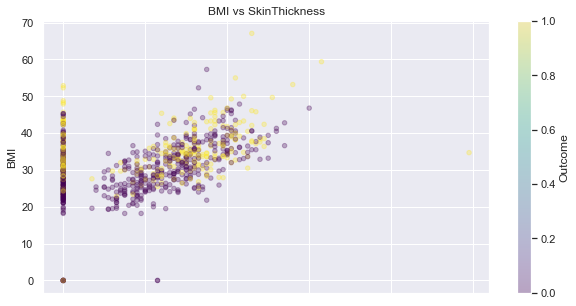

In [29]:
feat_1, feat_2 = 'BMI', 'SkinThickness'
display_scatter(df, feat_2, feat_1)

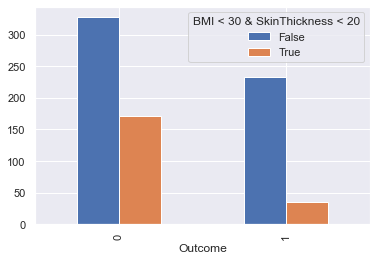

In [30]:
display_bars(df, feat_1, feat_2, 'BMI < 30 & SkinThickness < 20', 30, 20)

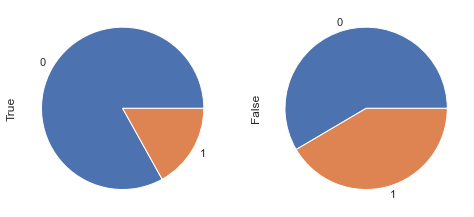

In [31]:
display_pie(df, feat_1, feat_2, 'BMI < 30 & SkinThickness < 20', 30, 20)

### Glucose and BMI

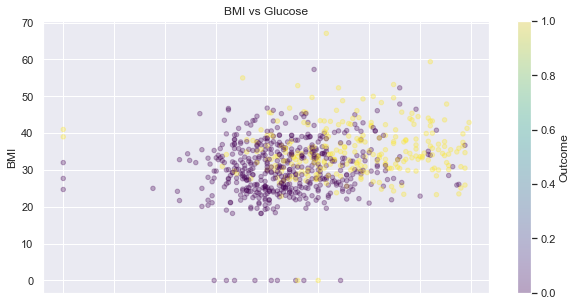

In [32]:
feat_1, feat_2 = 'BMI', 'Glucose'
display_scatter(df, feat_2, feat_1)

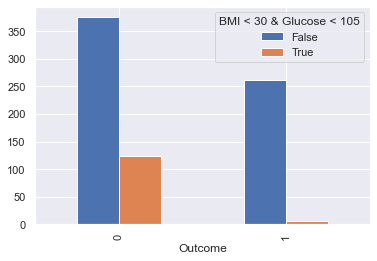

In [33]:
display_bars(df, feat_1, feat_2, 'BMI < 30 & Glucose < 105', 30, 105)

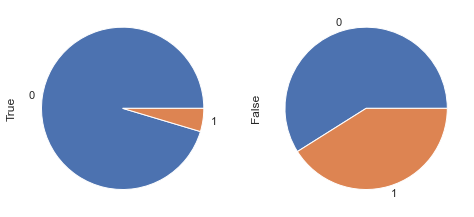

In [34]:
display_pie(df, feat_1, feat_2, 'BMI < 30 & Glucose < 105', 30, 105)

### Creation of new features

In [36]:
df_clean = df.copy()
for c in ['Glucose','BloodPressure','SkinThickness','Insulin','BMI', 'Age']:
    df_clean[c] = df_clean[c].replace(0, df_clean[c].median())

In [37]:
df_clean['new_feat_01'] = ((df_clean.Age < 30) & (df_clean.Glucose < 120)).astype(int)
df_clean['new_feat_02'] = ((df_clean.Age < 30) & (df_clean.Pregnancies < 6)).astype(int)
df_clean['new_feat_03'] = ((df_clean.Glucose < 105) & (df_clean.BloodPressure < 80)).astype(int)
df_clean['new_feat_04'] = ((df_clean.BMI < 30) & (df_clean.SkinThickness < 20)).astype(int)
df_clean['new_feat_05'] = ((df_clean.BMI < 30) & (df_clean.Glucose < 105)).astype(int)
#df_clean['new_feat_06'] = np.log(df_clean['BMI'] * df_clean['SkinThickness'])
df_clean['new_feat_07'] = df_clean['Pregnancies'] / df_clean['Age']
#df_clean['new_feat_08'] = np.log(df_clean['Glucose'] / df_clean['DiabetesPedigreeFunction'])
df_clean['new_feat_09'] = df_clean['Age'] * df_clean['DiabetesPedigreeFunction']
df_clean['new_feat_10'] = df_clean['Age'] / df_clean['Insulin']

---  

# Data preparation

### Removing weird values

As previously seen, there are strange value of zero that we should replace. I've tried the mean but the median seems to be a little better regarding the ML models' predictions:

### Dealing with outliers

There are still other outliers that we've to deal with. In a similar fashion let's replace them with the median:

In [38]:
def replace_outliers(df, c):
    """Replace the outliers of the column c of a dataframe df """
    Q1 = np.percentile(df_clean[c], 25)
    Q3 = np.percentile(df_clean[c], 75)
    IQR = Q3 - Q1
    step = IQR * 1.5
    df.loc[(df[c] <= Q1 - step) | (df[c] >= Q3 + step), c] = df[c].median()
    return df
    
for c in df_clean.drop("Outcome", axis=1).columns:
    df_clean = replace_outliers(df_clean, c)

We can see that this is much better now:

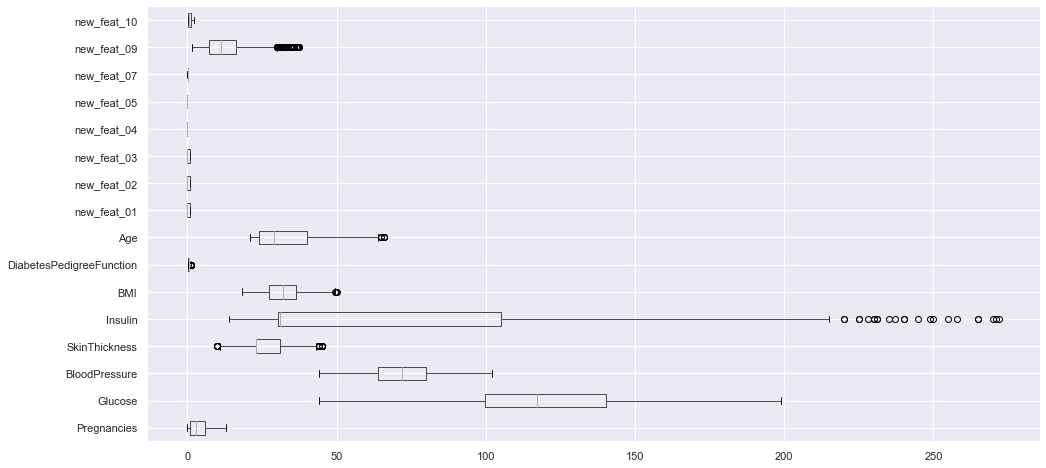

In [39]:
df_clean.loc[:, df_clean.columns != "Outcome"].boxplot(vert=False, figsize=(16, 8));

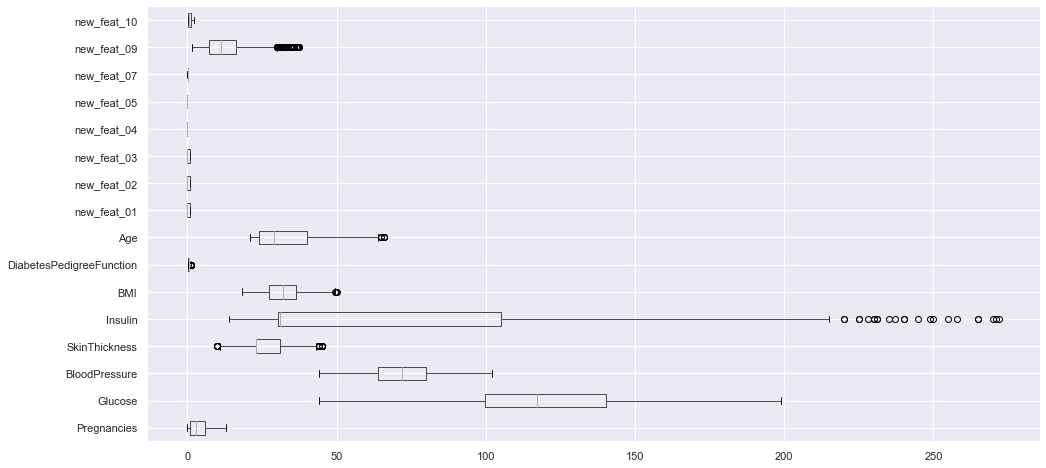

In [40]:
df_clean.loc[:, df_clean.columns != "Outcome"].boxplot(vert=False, figsize=(16, 8));

### Spliting

When selecting a model, we distinguish 3 different parts of the data that we have as follows:
- Training set:
    - Model is trained 
    - Usually 80% of the dataset

- Validation set:
    - Model is assessed 
    - Usually 20% of the dataset 

- Testing set
    - Model gives predictions
    - Unseen data  
![title](train.test.png)

First, the features and the target are separated:

In [41]:
#X = df_clean.loc[:, df.columns != "Outcome"]

X = df_clean.drop("Outcome", axis=1)
y = df_clean.Outcome
X.shape, y.shape

((768, 16), (768,))

Then the train and test sets are splitted:

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=54, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((614, 16), (154, 16), (614,), (154,))

### Scaling
Feature scaling is about transforming the value of features in the similar range like others for machine learning algorithms to behave better resulting in optimal models. It is not required for algorithms such as random forest or decision tree but needed for the kNN, SVM classifiers among others.  

Standardization and normalization are two most common techniques for feature scaling:  
- Normalization (MinMaxScaler) transforms the feature values to fall within the bounded intervals (min and max)
- Standardization (StandardScaler) transforms the feature values to fall around mean as 0 with standard deviation as 1

Standardization maintains useful information about outliers and makes the algorithm less sensitive to them in contrast to min-max scaling.  

Source: [Vitalflux.com](https://vitalflux.com/minmaxscaler-standardscaler-python-examples/)

In [43]:
ss = StandardScaler()
X_train_std = ss.fit_transform(X_train)
X_test_std = ss.transform(X_test)

## Model Performance / Metrics
This part is essential, to measure the performance of a model, we have several elements:

- __Confusion matrix__ : also known as the error matrix, allows visualization of the performance of an algorithm :  
    - true positive (TP) : Diabetic correctly identified as diabetic
    - true negative (TN) : Healthy correctly identified as healthy
    - false positive (FP) : Healthy incorrectly identified as diabetic
    - false negative (FN) : Diabetic incorrectly identified as healthy

- __Metrics__ :  
    - Accuracy : (TP +TN) / (TP + TN + FP +FN)
    - Precision : TP / (TP + FP)
    - Recall : TP / (TP + FN)
    - F1 score : 2 x ((Precision x Recall) / (Precision + Recall))

- __Roc Curve__ : The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.

- __Precision Recall Curve__ : shows the tradeoff between precision and recall for different threshold

The final choice of the best model won't be the same depending on the metric we are interested in. Here I'll use both accuracy and the ROC AUC, but the f1-score is also computed.

In [45]:
def plot_roc_curve(model, name, X_test, y_test):
    # predictions
    y_pred_proba = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba)
    
    # ROC curve
    plt.plot([0,1],[0,1],'k--') # diagonal
    plt.plot(fpr,tpr, label=str(model))
    plt.xlabel('fpr') ; plt.ylabel('tpr')
    plt.title(name + ' - ROC curve')
    plt.show()
    
    # display AUC & f1 score
    _auc = metrics.auc(fpr, tpr)
    _f1_score = metrics.f1_score(y_test, model.predict(X_test))
    print(f"{name}   -  AUC: {_auc:.2f}   -   F1-score: {_f1_score:.2f}")
    
    return _auc, _f1_score

In [46]:
# save results for later
acc_train, acc_test, auc, f1_score = [], [], [], []


def display_model_results(model, name, X_train, X_test, y_train, y_test):
    
    # model fitting
    model.fit(X_train_std, y_train)
        
    # display infos / metrics
    print(f"Tuned params: {model.best_params_} / best score: {model.best_score_:.2f}")
    _acc_train, _acc_test = model.score(X_train_std, y_train), model.score(X_test_std, y_test) 
    print(f"Accuracy on Train vs Test set: {_acc_train:.2f} / {_acc_test:.2f}")
    
    _auc, _f1_score = plot_roc_curve(model, name, X_test_std, y_test)
    
    # save results
    acc_train.append(_acc_train) ; acc_test.append(_acc_test)
    auc.append(_auc) ; f1_score.append(_f1_score)

# Training of various Models

Usually one starts with a simple model: a baseline, so that to be able to compare other models to the baseline. Then various models are trained, and the more interesting ones are kept and retrained in an optimized way (hyperparameters tuning). 
At the End, once the model has been chosen, it is trained on the entire dataset and tested on the unseen data in a production environnement.

Here i directly use grid search / random search cross validation for each type of model in order to keep the best one:

The k-fold cross-validation splits the training data into k folds to validate the model on one fold while training the model on the k − 1 other folds, all of this k times. The error is then averaged over the k folds and is named cross-validation error.

![title](kfold.png)

Fixed General settings for the models: the metrics for CV, the nb of k-folds, and the refitting of the model at the end of the CV.

In [47]:
scoring='accuracy'; cv=5; refit=True

Random search is a technique where random combinations of the hyperparameters are used to find the best solution for the built model. Generally RS is more faster and accurate than GridSearchCV who calculate all possible combinations. With Random Grid we specify the number of combinations that we want

### Logistic Regression

Tuned params: {'class_weight': 'None', 'penalty': 'none', 'solver': 'saga'} / best score: 0.78
Accuracy on Train vs Test set: 0.79 / 0.76


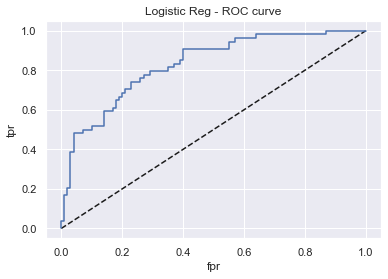

Logistic Reg   -  AUC: 0.83   -   F1-score: 0.63


In [48]:
from sklearn.linear_model import LogisticRegression

param_grid = {
    'penalty':['l1', 'l2', 'elasticnet', 'none'],
    'solver':['saga'],
    'class_weight':['balanced', 'None']
}
grid_lrc = GridSearchCV(LogisticRegression(), param_grid, scoring, cv, refit)
display_model_results(grid_lrc, "Logistic Reg", X_train_std, X_test_std, y_train, y_test)

### K-nearest neighbors (kNN)
- n_neighbors: Number of neighbors to use by default for k_neighbors queries

Tuned params: {'n_neighbors': 30} / best score: 0.74
Accuracy on Train vs Test set: 0.76 / 0.73


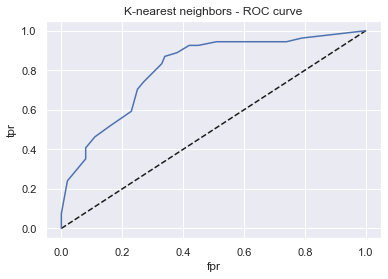

K-nearest neighbors   -  AUC: 0.81   -   F1-score: 0.57


In [49]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = {'n_neighbors':[5,10,15,25,30,50]}

grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid, scoring, cv, refit)
display_model_results(grid_knn, 'K-nearest neighbors', X_train_std, X_test_std, y_train, y_test)

### Decistion Tree
- max_depth: Maximum depth of the tree (double).
- row_subsample: Proportion of observations to consider (double).
- max_features: Proportion of columns (features) to consider in each level (double).

Tuned params: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 1} / best score: 0.73
Accuracy on Train vs Test set: 0.80 / 0.77


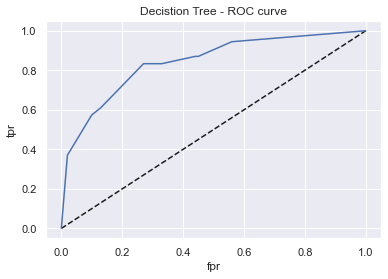

Decistion Tree   -  AUC: 0.84   -   F1-score: 0.71


In [50]:
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    'criterion':['gini','entropy'], 
    'max_depth':np.arange(2,10), 
    'min_samples_leaf':[0.2,0.4,0.6,0.8,0.9,1]
}
grid_dtc = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring, cv, refit)
display_model_results(grid_dtc, 'Decistion Tree', X_train, X_test, y_train, y_test)

### Support Vector Classifier - SVC
- C: The Penalty parameter C of the error term.
- Kernel: Kernel type could be linear, poly, rbf or sigmoid.

Tuned params: {'C': 0.9, 'gamma': 0.1, 'kernel': 'linear'} / best score: 0.78
Accuracy on Train vs Test set: 0.78 / 0.75


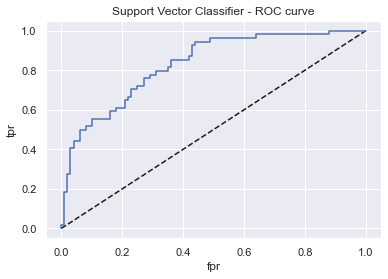

Support Vector Classifier   -  AUC: 0.83   -   F1-score: 0.61


In [51]:
from sklearn.svm import SVC

param_grid = {
    'kernel':[ 'linear' , 'poly' , 'rbf' , 'sigmoid' ],
    'C':[0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0],
    'gamma':[0.1,0.01,0.2,0.4]
}
grid_svc = GridSearchCV(SVC(probability=True), param_grid, scoring, cv, refit)
display_model_results(grid_svc, 'Support Vector Classifier', X_train_std, X_test_std, y_train, y_test)

### Random Forest

Tuned params: {'n_estimators': 200, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 5, 'criterion': 'gini'} / best score: 0.76
Accuracy on Train vs Test set: 0.87 / 0.74


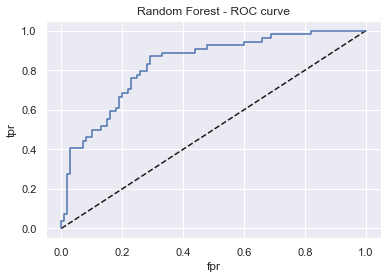

Random Forest   -  AUC: 0.83   -   F1-score: 0.60


In [52]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators':[200, 500, 1000],
    'max_depth':[2, 3, 4, 5],
    'min_samples_leaf':[0.2, 0.4, 0.6, 0.8, 1],
    'max_features':['auto', 'sqrt'],
    'criterion':['gini', 'entropy']}

grid_rfc = RandomizedSearchCV(RandomForestClassifier(), param_grid, n_iter=20, scoring='accuracy', cv=5, refit=True)
display_model_results(grid_rfc, 'Random Forest', X_train, X_test, y_train, y_test)

In [53]:
grid_rfc.best_params_

{'n_estimators': 200,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 5,
 'criterion': 'gini'}

importance of the different features (from the most influent to the less one):

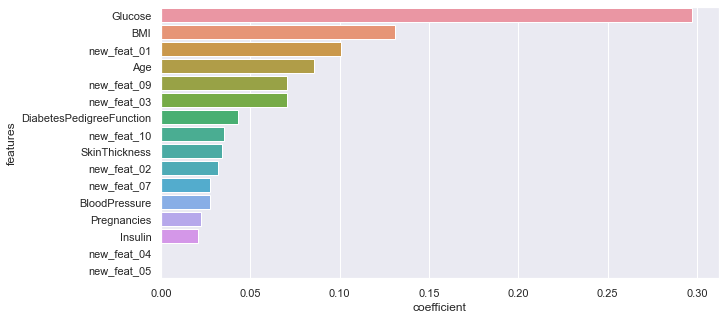

In [66]:
rf = RandomForestClassifier(n_estimators=500, min_samples_leaf=1, max_features='auto',
                            max_depth=4, criterion='gini').fit(X_train, y_train)

features = pd.DataFrame()
features["features"] = X_train.columns
features["coefficient"] = rf.feature_importances_

#features.sort_values('coefficient').plot.barh(x="features", y="coefficient");

features.sort_values(by=["coefficient"], ascending=False, inplace=True)
fig,ax= plt.subplots()
fig.set_size_inches(10,5)
sns.barplot(data=features, x="coefficient", y="features");

### AdaBoostClassifier
- learning_rate: Learning rate shrinks the contribution of each classifier by learning_rate.
- n_estimators: Number of trees to build.

Tuned params: {'learning_rate': 0.05, 'n_estimators': 200} / best score: 0.76
Accuracy on Train vs Test set: 0.80 / 0.76


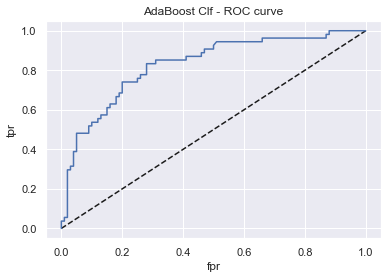

AdaBoost Clf   -  AUC: 0.83   -   F1-score: 0.62


In [55]:
from sklearn.ensemble import AdaBoostClassifier

param_grid = {
    'learning_rate':[.01, .05, .1, .5, 1],
    'n_estimators':[50, 100, 150, 200, 250, 300]
}
abc_rfc = GridSearchCV(AdaBoostClassifier(), param_grid, scoring, cv, refit)
display_model_results(abc_rfc, 'AdaBoost Clf', X_train, X_test, y_train, y_test)

### Gradient Boosting

Tuned params: {'learning_rate': 0.01, 'n_estimators': 300} / best score: 0.76
Accuracy on Train vs Test set: 0.86 / 0.75


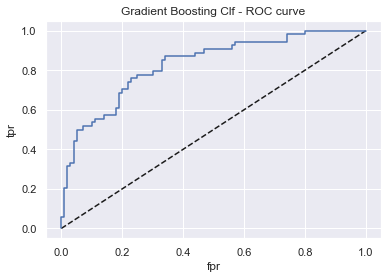

Gradient Boosting Clf   -  AUC: 0.83   -   F1-score: 0.62


In [56]:
from sklearn.ensemble import GradientBoostingClassifier

param_grid = {
    'learning_rate':[.01, .05, .1, .5, 1],
    'n_estimators':[50, 100, 150, 200, 250, 300]
}
gbc_rfc = GridSearchCV(GradientBoostingClassifier(), param_grid, scoring, cv, refit)
display_model_results(gbc_rfc, 'Gradient Boosting Clf', X_train, X_test, y_train, y_test)

importance of the different features (from the most influent to the less one):

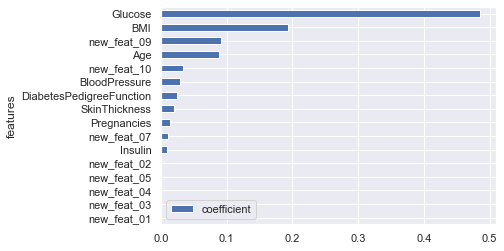

In [57]:
gb = GradientBoostingClassifier(n_estimators=250, learning_rate=0.01).fit(X_train, y_train)

features = pd.DataFrame()
features["features"] = X_train.columns
features["coefficient"] = gb.feature_importances_
features.sort_values('coefficient').plot.barh(x="features", y="coefficient");

### XGBoost Classifier

Tuned params: {'n_estimators': 400, 'max_depth': 2, 'learning_rate': 0.2, 'booster': 'gblinear'} / best score: 0.78
Accuracy on Train vs Test set: 0.79 / 0.76


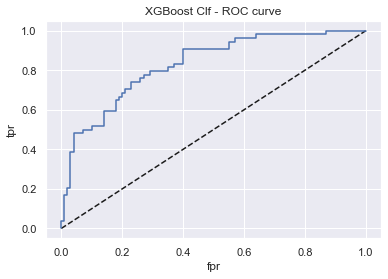

XGBoost Clf   -  AUC: 0.83   -   F1-score: 0.63


In [60]:
import xgboost as xgb

xgbcl = xgb.XGBClassifier(verbosity=0) # remove warnings

param_grid = {
    'booster':['gbtree', 'gblinear'],
    'learning_rate':[0.01, 0.1, 0.2, 0.4],
    'max_depth':[2, 3, 4, 6],
    'n_estimators':[200, 300, 400, 500]
}

grid_xgb = RandomizedSearchCV(xgbcl, param_grid, n_iter=30, cv=cv, refit=True)
display_model_results(grid_xgb, 'XGBoost Clf', X_train, X_test, y_train, y_test)

### LightGBM

LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

- Faster training speed and higher efficiency.
- Lower memory usage.
- Better accuracy.
- Support of parallel and GPU learning.
- Capable of handling large-scale data.
- To find the best hyperparameters, we'll use Random Search CV.



LightGBM : Hyperparameters :

- learning_rate : This determines the impact of each tree on the final outcome. GBM works by starting with an initial estimate which is updated using the output of each tree. The learning parameter controls the magnitude of this change in the estimates
- n_estimators : number of trees (or rounds)
- num_leaves : number of leaves in full tree, default: 31
- min_child_samples : minimal number of data in one leaf. Can be used to deal with over-fitting
- min_child_weight : minimal sum hessian in one leaf.
- subsample : randomly select part of data without resampling
- max_depth : It describes the maximum depth of tree. This parameter is used to handle model overfitting.
- colsample_bytree : LightGBM will randomly select part of features on each iteration if colsample_bytree smaller than 1.0. For example, if you set it to 0.8, LightGBM will select 80% of features before training each tree
- reg_alpha : regularization
- reg_lambda : regularization
- early_stopping_rounds : This parameter can help you speed up your analysis. Model will stop training if one metric of one validation data doesn’t improve in last early_stopping_round rounds. This will reduce excessive iterations

In [69]:
random_state=42

fit_params = {"early_stopping_rounds" : 100, 
             "eval_metric" : 'auc', 
             "eval_set" : [(X,y)],
             'eval_names': ['valid'],
             'verbose': 0,
             'categorical_feature': 'auto'}

param_test = {'learning_rate' : [0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4],
              'n_estimators' : [100, 200, 300, 400, 500, 600, 800, 1000, 1500, 2000],
              'num_leaves': sp_randint(6, 50), 
              'min_child_samples': sp_randint(100, 500), 
              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
              'subsample': sp_uniform(loc=0.2, scale=0.8), 
              'max_depth': [-1, 1, 2, 3, 4, 5, 6, 7],
              'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
              'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

#number of combinations
n_iter = 300

#intialize lgbm and lunch the search
lgbm_clf = lgbm.LGBMClassifier(random_state=random_state, silent=True, metric='None', n_jobs=4)
grid_search = RandomizedSearchCV(
    estimator=lgbm_clf, param_distributions=param_test, 
    n_iter=n_iter,
    scoring='accuracy',
    cv=5,
    refit=True,
    random_state=random_state,
    verbose=True)

grid_search.fit(X, y, **fit_params)
opt_parameters =  grid_search.best_params_
lgbm_clf = lgbm.LGBMClassifier(**opt_parameters)

NameError: name 'lgbm' is not defined

---

# Conclusion

As you can see all the models we've tried perform quite the same way. On average the accuracies on Train vs Test set are 0.78 / 0.77 while the Area Under the Curve AUC is 0.82 (F1-score = 0.65)

In fact, the real difference is made during the data preparation / feature engineering part but according to the random forrest not all new features are usefull.  I've kept the results but you can give it a try by yourself (just run  only few parts of this notebook...). Here are other ideas you use if you want to increase your model's results:

- Use class weights
- Lightgbm can also be a good bet, Vincent Lugat has made an interesting graph which indicates [the discrimination threshold](https://www.kaggle.com/code/vincentlugat/pima-indians-diabetes-eda-prediction-0-906?scriptVersionId=27685252&cellId=171).
- He has also used a VotingClassifier (from sklearn) as a meta-classifier for combining similar or conceptually different machine learning classifiers for classification via majority or plurality voting (here LightGBM & KNN clf). This kind of stacked models can usually perform better.

In [62]:
print('\033[1m' + 'Thank you for reading :)'
      '\033[0m')

Thank you for reading :)


### Credits:
- [Step by Step Diabetes Classification-KNN-detailed by SHRUTI_IYYER](https://www.kaggle.com/code/shrutimechlearn/step-by-step-diabetes-classification-knn-detailed)
- [Outliers the silent killer by NARESH BHAT](https://www.kaggle.com/code/nareshbhat/outlier-the-silent-killer)
- [Pima Indians Diabetes - EDA & Prediction by VINCENT LUGAT](https://www.kaggle.com/code/vincentlugat/pima-indians-diabetes-eda-prediction-0-906)
- [Machine Learning & Predictive Modeling Analytics by RAVI CHAUBEY](https://www.kaggle.com/code/ravichaubey1506/machine-learning-predictive-modeling-analytics)
- [Multivariate Statistical Analysis on Diabetes by RAVI CHAUBEY](https://www.kaggle.com/code/ravichaubey1506/multivariate-statistical-analysis-on-diabetes)
- [Interpreting ML models by PARUL PANDEY](https://www.kaggle.com/code/parulpandey/intrepreting-machine-learning-models)